In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kmader_food41_path = kagglehub.dataset_download('gauravduttakiit/food-image-classification')
mujawar_efficientnetb0_notop_h5_path = kagglehub.dataset_download('mujawar/efficientnetb0-notop-h5')
randooo_pizzafile_path = kagglehub.dataset_download('randooo/pizzafile')

print('Data source import complete.')


Using Colab cache for faster access to the 'food-image-classification' dataset.
Using Colab cache for faster access to the 'efficientnetb0-notop-h5' dataset.
Using Colab cache for faster access to the 'pizzafile' dataset.
Data source import complete.


Importing libraries for the model for CNN


In [ ]:
# Installations and imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Clear memory and setup device
import gc
gc.collect()

# SIMPLE GPU SETUP - PyTorch way
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Detailed GPU info
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"CUDA version: {torch.version.cuda}")

    # Test GPU with a simple operation
    x = torch.randn(1000, 1000).cuda()
    y = torch.randn(1000, 1000).cuda()
    z = torch.matmul(x, y)
    print(f"GPU test successful! Result shape: {z.shape}")
    print(f"GPU memory allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

# Define Google Drive paths
DRIVE_PATH = "/content/drive/MyDrive"
MODEL_SAVE_NAME = "foodtrainer.h5"
CLASSES_SAVE_NAME = "foodtrainer_classes.json"
TRAINER_STATE_NAME = "foodtrainer_state.pth"

Using device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB
CUDA version: 12.6
GPU test successful! Result shape: torch.Size([1000, 1000])
GPU memory allocated: 0.02 GB


CNN used primarily for image recognition and processing, due to its ability to recognise patterns in images.

Data Loading and Preprocesing



In [ ]:
def create_pytorch_dataloaders(batch_size=128, img_size=224, validation_split=0.2):  
    """Create PyTorch data loaders from your food dataset"""

    # Data transforms
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Load dataset
    data_path = kmader_food41_path
    train_path = os.path.join(data_path, "train")

    full_dataset = ImageFolder(root=train_path, transform=train_transform)

    # Split dataset
    dataset_size = len(full_dataset)
    val_size = int(validation_split * dataset_size)
    train_size = dataset_size - val_size

    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size]
    )

    # Apply validation transform to val dataset
    val_dataset.dataset.transform = val_transform

    # Create data loaders with GPU optimization 
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,  
        shuffle=True,
        num_workers=4,  
        pin_memory=True  # Faster GPU transfer
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,  
        pin_memory=True
    )

    class_names = full_dataset.classes
    print(f"Found {len(class_names)} classes")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Batches per epoch: {len(train_loader)}")
    print(f"Effective batch size: {batch_size}")

    return train_loader, val_loader, class_names

Training the Model and Model Architecture




In [ ]:
class FoodClassifierPyTorch(nn.Module):
    def __init__(self, num_classes):
        super(FoodClassifierPyTorch, self).__init__()

        # Use EfficientNet
        self.backbone = models.efficientnet_b0(pretrained=True)

        # Freeze backbone initially
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Replace classifier - store it as self.classifier for easy access
        in_features = self.backbone.classifier[1].in_features
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        # Replace the backbone's classifier with our custom classifier
        self.backbone.classifier = self.classifier

    def forward(self, x):
        return self.backbone(x)

    def unfreeze_backbone(self):
        """Unfreeze for fine-tuning"""
        for param in self.backbone.parameters():
            param.requires_grad = True

In [ ]:
class PyTorchFoodTrainer:
    def __init__(self, model, train_loader, val_loader, class_names):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.class_names = class_names
        self.device = device

        self.current_epoch = 0
        self.total_epochs_trained = 0
        self.is_fine_tuning = False

        # Load previous state if exists
        self._load_state()

    def _load_state(self):
        """Load previous training state from Google Drive"""
        try:
            state_path = os.path.join(DRIVE_PATH, TRAINER_STATE_NAME)
            if os.path.exists(state_path):
                checkpoint = torch.load(state_path, map_location=self.device)
                self.model.load_state_dict(checkpoint['model_state_dict'])
                self.current_epoch = checkpoint['epoch']
                self.total_epochs_trained = checkpoint['total_epochs']
                self.is_fine_tuning = checkpoint['is_fine_tuning']
                print(f"✅ Loaded previous state: Epoch {self.current_epoch}, Fine-tuning: {self.is_fine_tuning}")
        except Exception as e:
            print(f"⚠️ No previous state found or error loading: {e}")
            print("Starting fresh training...")

    def _save_to_drive(self, epoch, total_epochs, is_fine_tuning):
        """Save everything to Google Drive with foodtrainer.h5 filename"""

        # Save model state dict as foodtrainer.h5
        model_path = os.path.join(DRIVE_PATH, MODEL_SAVE_NAME)
        torch.save(self.model.state_dict(), model_path)

        # Save class names
        classes_path = os.path.join(DRIVE_PATH, CLASSES_SAVE_NAME)
        with open(classes_path, 'w') as f:
            json.dump(self.class_names, f, indent=2)

        # Save training state
        state_path = os.path.join(DRIVE_PATH, TRAINER_STATE_NAME)
        torch.save({
            'epoch': epoch,
            'total_epochs': total_epochs,
            'is_fine_tuning': is_fine_tuning,
            'model_state_dict': self.model.state_dict(),
        }, state_path)

        print("💾 Saved to Google Drive:")
        print(f"   - Model: {MODEL_SAVE_NAME}")
        print(f"   - Classes: {CLASSES_SAVE_NAME}")
        print(f"   - Training state: {TRAINER_STATE_NAME}")

    def get_status(self):
        """Get current training status"""
        # Count trainable parameters
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in self.model.parameters())

        status = f"""
        📊 Training Status:
          - Current Epoch: {self.current_epoch}
          - Total Epochs Trained: {self.total_epochs_trained}
          - Mode: {'Fine-tuning' if self.is_fine_tuning else 'Initial Training'}
          - Trainable Parameters: {trainable_params:,} / {total_params:,}
          - Backbone Frozen: {not any(param.requires_grad for param in self.model.backbone.parameters())}
        """
        print(status)

    def _train_epochs(self, epochs, optimizer, criterion, fine_tune=False):
        """Internal training function"""
        train_losses = []
        val_accuracies = []

        start_epoch = self.current_epoch
        end_epoch = self.current_epoch + epochs

        for epoch in range(start_epoch, end_epoch):
            # Training phase
            self.model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for batch_idx, (images, labels) in enumerate(self.train_loader):
                images, labels = images.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Calculate training accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                # Print progress every 50 batches
                if batch_idx % 10 == 0:
                    print(f'  Batch {batch_idx}/{len(self.train_loader)}, Loss: {loss.item():.4f}')

            # Validation phase
            self.model.eval()
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for images, labels in self.val_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    outputs = self.model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            # Calculate metrics
            train_accuracy = 100 * correct_train / total_train
            val_accuracy = 100 * correct_val / total_val
            avg_loss = running_loss / len(self.train_loader)

            train_losses.append(avg_loss)
            val_accuracies.append(val_accuracy)

            print(f'Epoch [{epoch+1}/{end_epoch}]')
            print(f'  Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

            # Update counters
            self.current_epoch += 1
            self.total_epochs_trained += 1

            # Clear GPU cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        return train_losses, val_accuracies

    def train_initial(self, epochs=5, learning_rate=0.001):
        """Initial training with frozen backbone"""
        if self.is_fine_tuning:
            print("⚠️ Model is already in fine-tuning mode. Use continue_fine_tuning() instead.")
            return

        print(f"🚀 Starting initial training for {epochs} epochs...")

        # Ensure backbone is frozen and classifier is trainable
        for param in self.model.backbone.parameters():
            param.requires_grad = False
        for param in self.model.classifier.parameters():
            param.requires_grad = True

        # Get trainable parameters for debugging
        trainable_params = [param for param in self.model.parameters() if param.requires_grad]
        print(f"Training {len(trainable_params)} parameter groups")

        # Create optimizer with ALL trainable parameters
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        train_losses, val_accuracies = self._train_epochs(
            epochs, optimizer, criterion, fine_tune=False
        )

        self._save_to_drive(
            self.current_epoch,
            self.total_epochs_trained,
            self.is_fine_tuning
        )

        return train_losses, val_accuracies

    def continue_initial(self, additional_epochs=5, learning_rate=0.001):
        """Continue initial training"""
        if self.is_fine_tuning:
            print("⚠️ Model is in fine-tuning mode. Use continue_fine_tuning() instead.")
            return

        print(f"🔄 Continuing initial training for {additional_epochs} more epochs...")
        print(f"Starting from epoch {self.current_epoch}")

        # Ensure correct parameters are trainable
        for param in self.model.backbone.parameters():
            param.requires_grad = False
        for param in self.model.classifier.parameters():
            param.requires_grad = True

        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        train_losses, val_accuracies = self._train_epochs(
            additional_epochs, optimizer, criterion, fine_tune=False
        )

        self._save_to_drive(
            self.current_epoch,
            self.total_epochs_trained,
            self.is_fine_tuning
        )

        return train_losses, val_accuracies

    def start_fine_tuning(self, additional_epochs=5, learning_rate=0.0001):
        """Start fine-tuning (unfreeze backbone)"""
        print(f"🔥 Starting fine-tuning for {additional_epochs} epochs...")

        # Unfreeze backbone
        self.model.unfreeze_backbone()
        self.is_fine_tuning = True

        # Create optimizer with all parameters
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        train_losses, val_accuracies = self._train_epochs(
            additional_epochs, optimizer, criterion, fine_tune=True
        )

        self._save_to_drive(
            self.current_epoch,
            self.total_epochs_trained,
            self.is_fine_tuning
        )

        return train_losses, val_accuracies

    def continue_fine_tuning(self, additional_epochs=5, learning_rate=0.0001):
        """Continue fine-tuning"""
        if not self.is_fine_tuning:
            print("⚠️ Model is not in fine-tuning mode. Use start_fine_tuning() first.")
            return

        print(f"🔄 Continuing fine-tuning for {additional_epochs} more epochs...")
        print(f"Starting from epoch {self.current_epoch}")

        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        train_losses, val_accuracies = self._train_epochs(
            additional_epochs, optimizer, criterion, fine_tune=True
        )

        self._save_to_drive(
            self.current_epoch,
            self.total_epochs_trained,
            self.is_fine_tuning
        )

        return train_losses, val_accuracies

Memory Management for Continuous Trainer

In [ ]:
# Load data
print("Loading data...")
train_loader, val_loader, class_names = create_pytorch_dataloaders(
    batch_size=8,
    img_size=224
)

# Create model
print("Creating model...")
num_classes = len(class_names)
model = FoodClassifierPyTorch(num_classes).to(device)

print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Loading data...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weight

Found 34 classes
Training samples: 15279
Validation samples: 3819
Batches per epoch: 1910
Effective batch size: 8
Creating model...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 118MB/s] 


Model has 4,175,902 parameters
Trainable parameters: 168,354


In [ ]:
# Recreate model with fixed architecture
print("Creating model with fixed architecture...")
num_classes = len(class_names)
model = FoodClassifierPyTorch(num_classes).to(device)

print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Create trainer
trainer = PyTorchFoodTrainer(model, train_loader, val_loader, class_names)

# Show initial status
trainer.get_status()

# Start initial training
print("Starting initial training...")
train_losses, val_accuracies = trainer.train_initial(epochs=2)  # Starting with 2 epochs to test

print("✅ Initial training completed!")
trainer.get_status()

Creating model with fixed architecture...
Model has 4,175,902 parameters
Trainable parameters: 168,354
✅ Loaded previous state: Epoch 50, Fine-tuning: True

        📊 Training Status:
          - Current Epoch: 50
          - Total Epochs Trained: 50
          - Mode: Fine-tuning
          - Trainable Parameters: 168,354 / 4,175,902
          - Backbone Frozen: False
        
Starting initial training...
⚠️ Model is already in fine-tuning mode. Use continue_fine_tuning() instead.


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# Start initial training
print("Starting initial training...")
train_losses, val_accuracies = trainer.train_initial(epochs=5)

print("✅ Initial training completed!")
trainer.get_status()

Starting initial training...
⚠️ Model is already in fine-tuning mode. Use continue_fine_tuning() instead.


TypeError: cannot unpack non-iterable NoneType object

Fine-tuning of the model

In [ ]:
## MODEL EVALUATION

# Start fine-tuning
print("Starting fine-tuning...")
train_losses_ft, val_accuracies_ft = trainer.start_fine_tuning(additional_epochs=5)

print("🎉 Fine-tuning completed!")
trainer.get_status()

Starting fine-tuning...
🔥 Starting fine-tuning for 5 epochs...
  Batch 0/1910, Loss: 0.0695
  Batch 10/1910, Loss: 0.5984
  Batch 20/1910, Loss: 0.0161
  Batch 30/1910, Loss: 0.0069
  Batch 40/1910, Loss: 0.0297
  Batch 50/1910, Loss: 0.2247
  Batch 60/1910, Loss: 0.0056
  Batch 70/1910, Loss: 0.0103
  Batch 80/1910, Loss: 0.0030
  Batch 90/1910, Loss: 0.1015
  Batch 100/1910, Loss: 0.0008
  Batch 110/1910, Loss: 0.0254
  Batch 120/1910, Loss: 0.0084
  Batch 130/1910, Loss: 0.0102
  Batch 140/1910, Loss: 0.0685
  Batch 150/1910, Loss: 0.0083
  Batch 160/1910, Loss: 0.0015
  Batch 170/1910, Loss: 0.0334
  Batch 180/1910, Loss: 0.0009
  Batch 190/1910, Loss: 0.0077
  Batch 200/1910, Loss: 0.5700
  Batch 210/1910, Loss: 0.2878
  Batch 220/1910, Loss: 0.0004
  Batch 230/1910, Loss: 0.0072
  Batch 240/1910, Loss: 0.2398
  Batch 250/1910, Loss: 0.2205
  Batch 260/1910, Loss: 0.0054
  Batch 270/1910, Loss: 0.0453
  Batch 280/1910, Loss: 0.1265
  Batch 290/1910, Loss: 0.1180
  Batch 300/1910, 

In [ ]:
# Verify files are saved
print("\n📁 Verifying saved files in Google Drive:")
drive_files = os.listdir(DRIVE_PATH)
saved_files = [f for f in [MODEL_SAVE_NAME, CLASSES_SAVE_NAME, TRAINER_STATE_NAME] if f in drive_files]

for file in saved_files:
    file_path = os.path.join(DRIVE_PATH, file)
    file_size = os.path.getsize(file_path) / (1024*1024)  # Size in MB
    print(f"✅ {file} - {file_size:.1f} MB")

print(f"\nYour model is saved as: {os.path.join(DRIVE_PATH, MODEL_SAVE_NAME)}")
print("🎊 All done! Your food classifier is ready to use!")


📁 Verifying saved files in Google Drive:
✅ foodtrainer.h5 - 16.2 MB
✅ foodtrainer_classes.json - 0.0 MB
✅ foodtrainer_state.pth - 16.2 MB

Your model is saved as: /content/drive/MyDrive/foodtrainer.h5
🎊 All done! Your food classifier is ready to use!


Saving model


In [ ]:

class FoodPredictor:
    def __init__(self, model_path, classes_path, device='cuda'):
        self.device = device
        self.model_path = model_path
        self.classes_path = classes_path

        # Load class names
        with open(classes_path, 'r') as f:
            self.class_names = json.load(f)

        # Create model architecture
        self.model = FoodClassifierPyTorch(len(self.class_names)).to(device)

        # Load trained weights
        self.model.load_state_dict(torch.load(model_path, map_location=device))
        self.model.eval()

        # Define image transforms (same as validation)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        print(f"✅ Predictor loaded: {len(self.class_names)} classes")

    def predict_image(self, image_path):
        """Predict a single image"""
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # Predict
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

        # Get top predictions
        top_probs, top_indices = torch.topk(probabilities, 5)

        results = {
            'predicted_class': self.class_names[top_indices[0].item()],
            'confidence': top_probs[0].item() * 100,
            'top_predictions': []
        }

        for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
            results['top_predictions'].append({
                'rank': i + 1,
                'class': self.class_names[idx.item()],
                'confidence': prob.item() * 100
            })

        return results

    def display_prediction(self, image_path):
        """Display image with prediction"""
        results = self.predict_image(image_path)

        # Display image
        image = Image.open(image_path)
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Input Image")

        plt.subplot(1, 2, 2)
        # Create bar chart of top predictions
        classes = [pred['class'] for pred in results['top_predictions']]
        confidences = [pred['confidence'] for pred in results['top_predictions']]

        colors = ['green' if i == 0 else 'blue' for i in range(len(classes))]
        plt.barh(classes, confidences, color=colors)
        plt.xlabel('Confidence (%)')
        plt.title('Top Predictions')
        plt.gca().invert_yaxis()

        plt.tight_layout()
        plt.show()

        return results

# Initialize predictor
predictor = FoodPredictor(
    model_path=os.path.join(DRIVE_PATH, MODEL_SAVE_NAME),
    classes_path=os.path.join(DRIVE_PATH, CLASSES_SAVE_NAME),
    device=device
)

print("🎯 Food Predictor is ready to use!")

✅ Predictor loaded: 34 classes
🎯 Food Predictor is ready to use!


In [ ]:
# Optional: Test loading the saved model
def test_loaded_model():
    """Test that we can load the saved model"""
    print("\n🧪 Testing model loading...")

    # Create a new model instance
    test_model = FoodClassifierPyTorch(num_classes).to(device)

    # Load saved weights
    model_path = os.path.join(DRIVE_PATH, MODEL_SAVE_NAME)
    test_model.load_state_dict(torch.load(model_path, map_location=device))
    test_model.eval()

    print("✅ Model loaded successfully!")

    # Load class names
    classes_path = os.path.join(DRIVE_PATH, CLASSES_SAVE_NAME)
    with open(classes_path, 'r') as f:
        loaded_class_names = json.load(f)

    print(f"✅ Classes loaded: {len(loaded_class_names)} classes")

    return test_model, loaded_class_names

# Uncomment to test:
test_model, loaded_classes = test_loaded_model()


🧪 Testing model loading...
✅ Model loaded successfully!
✅ Classes loaded: 34 classes


Loading Model for Inference

In [ ]:
# Test with sample images
def test_sample_images():
    """Test the model with sample images"""
    print("🧪 Testing with sample images...")

   
    sample_images = []

    # Check if we have any images in the current directory
    image_extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']
    current_dir_files = os.listdir('.')
    image_files = [f for f in current_dir_files if any(f.endswith(ext) for ext in image_extensions)]

    if image_files:
        sample_images = image_files[:3]  # Test with up to 3 images
        print(f"Found {len(sample_images)} images in current directory")
    else:
        print("No images found in current directory.")
        print("Please upload some food images to test, or use the pizza dataset")
        return

    # Test each image
    for i, image_file in enumerate(sample_images):
        print(f"\n--- Testing Image {i+1}: {image_file} ---")
        try:
            results = predictor.display_prediction(image_file)
            print(f"🏆 Top prediction: {results['predicted_class']} ({results['confidence']:.2f}%)")
        except Exception as e:
            print(f"❌ Error processing {image_file}: {e}")

# Run sample tests
test_sample_images()

🧪 Testing with sample images...
No images found in current directory.
Please upload some food images to test, or use the pizza dataset


Production-Ready Inference Function

📤 Upload food images to test...
Supported formats: JPG, JPEG, PNG
Click 'Choose Files' below to select images from your computer
--------------------------------------------------


Saving image_2025-10-02_144015175.png to image_2025-10-02_144015175.png
✅ Successfully uploaded 1 file(s)

🍕 Testing: image_2025-10-02_144015175.png


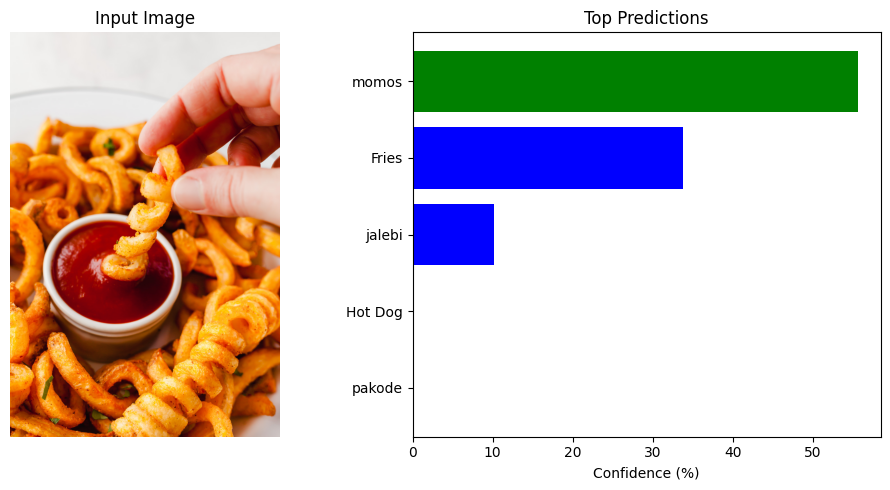


🏆 PREDICTION RESULTS:
   Food: momos
   Confidence: 55.67%

📊 TOP 5 PREDICTIONS:
   1. momos: 55.67%
   2. Fries: 33.76%
   3. jalebi: 10.10%
   4. Hot Dog: 0.17%
   5. pakode: 0.15%


In [ ]:
# Upload and Test Images
from google.colab import files
import io
from PIL import Image

def upload_and_test_images():
    """Upload images and test them with your food classifier"""
    print("📤 Upload food images to test...")
    print("Supported formats: JPG, JPEG, PNG")
    print("Click 'Choose Files' below to select images from your computer")
    print("-" * 50)

    # Upload files
    uploaded = files.upload()

    if not uploaded:
        print("❌ No files were uploaded. Please try again.")
        return

    print(f"✅ Successfully uploaded {len(uploaded)} file(s)")

    # Test each uploaded image
    for filename in uploaded.keys():
        print(f"\n" + "="*60)
        print(f"🍕 Testing: {filename}")
        print("="*60)

        try:
            # Display and test the image
            results = predictor.display_prediction(filename)

            print(f"\n🏆 PREDICTION RESULTS:")
            print(f"   Food: {results['predicted_class']}")
            print(f"   Confidence: {results['confidence']:.2f}%")

            print(f"\n📊 TOP 5 PREDICTIONS:")
            for pred in results['top_predictions']:
                print(f"   {pred['rank']}. {pred['class']}: {pred['confidence']:.2f}%")

        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")

# Run the upload function
upload_and_test_images()

In [ ]:
# Comprehensive model evaluation
def evaluate_model(model, val_loader, class_names):
    """Evaluate model on validation set"""
    print("📊 Evaluating model on validation set...")

    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)

    # Calculate overall accuracy
    accuracy = 100 * np.sum(all_predictions == all_labels) / len(all_labels)
    print(f"✅ Overall Accuracy: {accuracy:.2f}%")

    return all_predictions, all_labels, all_probabilities, accuracy

# Run evaluation
print("Starting model evaluation...")
all_preds, all_labels, all_probs, overall_accuracy = evaluate_model(
    model, val_loader, class_names
)

Starting model evaluation...
📊 Evaluating model on validation set...
✅ Overall Accuracy: 98.72%


In [ ]:
# Generate detailed classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def generate_detailed_report(all_preds, all_labels, class_names):
    """Generate detailed classification report and confusion matrix"""

    print("\n" + "="*60)
    print("📈 DETAILED CLASSIFICATION REPORT")
    print("="*60)

    # Classification report
    print("\n📋 Classification Report:")
    print(classification_report(all_labels, all_preds,
                              target_names=class_names,
                              zero_division=0))

    # Per-class accuracy
    print("\n🎯 Per-Class Accuracy:")
    class_correct = np.zeros(len(class_names))
    class_total = np.zeros(len(class_names))

    for i in range(len(class_names)):
        mask = (all_labels == i)
        if np.sum(mask) > 0:
            class_correct[i] = np.sum(all_preds[mask] == i)
            class_total[i] = np.sum(mask)
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f"  {class_names[i]:<20}: {accuracy:6.2f}% ({int(class_correct[i])}/{int(class_total[i])})")

    # Worst performing classes
    print(f"\n🔴 Top 5 Worst Performing Classes:")
    class_accuracies = []
    for i in range(len(class_names)):
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            class_accuracies.append((class_names[i], accuracy, int(class_correct[i]), int(class_total[i])))

    # Sort by accuracy (ascending)
    class_accuracies.sort(key=lambda x: x[1])

    for i, (class_name, acc, correct, total) in enumerate(class_accuracies[:5]):
        print(f"  {i+1}. {class_name:<20}: {acc:6.2f}% ({correct}/{total})")

    # Best performing classes
    print(f"\n🟢 Top 5 Best Performing Classes:")
    for i, (class_name, acc, correct, total) in enumerate(class_accuracies[-5:][::-1]):
        print(f"  {i+1}. {class_name:<20}: {acc:6.2f}% ({correct}/{total})")

    return class_accuracies

# Generate detailed report
class_accuracies = generate_detailed_report(all_preds, all_labels, class_names)


📈 DETAILED CLASSIFICATION REPORT

📋 Classification Report:
                precision    recall  f1-score   support

  Baked Potato       0.99      1.00      0.99       263
Crispy Chicken       0.99      0.97      0.98       243
         Donut       1.00      1.00      1.00       268
         Fries       0.99      0.99      0.99       245
       Hot Dog       0.98      1.00      0.99       240
      Sandwich       0.99      0.99      0.99       233
          Taco       0.99      0.95      0.97       226
       Taquito       0.97      0.99      0.98       232
     apple_pie       0.97      0.98      0.98       180
        burger       1.00      0.98      0.99        50
   butter_naan       0.96      1.00      0.98        50
          chai       1.00      0.98      0.99        51
       chapati       1.00      1.00      1.00        54
    cheesecake       0.99      0.97      0.98       167
 chicken_curry       0.99      0.98      0.99       146
 chole_bhature       0.98      0.98      0.